In [1]:
import emcee
import george
import corner
import numpy as np
import pandas as pd
import astropy.io.fits as fits
import matplotlib.pyplot as plt

from george import kernels
from george.modeling import Model
from scipy.optimize import minimize
from astropy.timeseries import LombScargle

# --- Imports
import copy
import radvel
import george
import pypolychord

import numpy as np
from george import kernels
from pypolychord.settings import PolyChordSettings

import prior_transforms as pt
from pickle_data import load_data_from_pickle

# --- Parameter configuration
INCLUDE_PLANET_B = False

# --- Output directory
output_dir = "L98_59_aldo/polychord_out"
cluster_dir = "L98_59_aldo/polychord_out/clusters"

# --- Import relevant data
pickle_file_path = "../datasets/cleaned_data_20240531.pickle"
X = load_data_from_pickle(pickle_file_path)
X_pre, X_post, X_harps = X["ESPRESSO_pre"], X["ESPRESSO_post"], X["HARPS"]
n_pre, n_post, n_harps = len(X_pre["RV"]), len(X_post["RV"]), len(X_harps["RV"])

In [2]:
ESPRESSO_df = pd.concat([X_pre, X_post], ignore_index=True)
ESPRESSO_times = np.block([X_pre["Time"], X_post["Time"]])
HARPS_df = X_harps
HARPS_times = X_harps["Time"]
time = np.concatenate([ESPRESSO_times, HARPS_times])

In [3]:
cleaned_HARPS_df = HARPS_df.dropna(subset=['FWHM', 'BIS'])
mask = HARPS_df[['FWHM', 'BIS']].notna().all(axis=1)

cleaned_times = HARPS_df.loc[mask, ['Time']]

In [4]:
cleaned_times

,Time
0,2.458409e+06
1,2.458410e+06
2,2.458413e+06
3,2.458414e+06
4,2.458415e+06
...,...
134,2.458569e+06
135,2.458570e+06
136,2.458570e+06
137,2.458571e+06


In [5]:
min_frequency = 1 / (time.max() - time.min())  # Longest period
max_frequency = 1 / (2 * np.median(np.diff(time)))  # Nyquist frequency
samples_per_peak = 3000

print(f'Minimum frequency: {min_frequency:}')
print(f'Maximum frequency: {max_frequency:}')

Minimum frequency: 0.0019167233230466848
Maximum frequency: 0.5052102331671597


In [12]:
# convert frequency to microhertz
def convert_to_microhertz(frequency_in_days):
    return frequency_in_days * 1e6 / 86400

# convert microhertz to frequency
def convert_to_days(frequency_in_microhertz):
    return frequency_in_microhertz * 86400 / 1e6

# Perform the Lomb-Scargle periodogram
def compute_periodogram(time, data, min_frequency=min_frequency, max_frequency=max_frequency, samples_per_peak=samples_per_peak, ESPRESSO=False):

    frequency, power = LombScargle(time, data).autopower(
        minimum_frequency=min_frequency,
        maximum_frequency=max_frequency,
        normalization='standard',
        samples_per_peak=samples_per_peak
        )
    fap_levels = [0.001, 0.01, 0.1]
    fap_thresholds = LombScargle(time, data).false_alarm_level(fap_levels)
    return frequency, power, fap_thresholds


def frequency_to_period(frequency):
    # Assuming frequency is in microhertz, convert to period in days
    return 1 / (frequency * 86400 * 1e-6)


def plot_periodogram(time, data, activity_indices, true_periods, period_colors, min_frequency=min_frequency, max_frequency=max_frequency, samples_per_peak=samples_per_peak, ESPRESSO=False):
    # Compute periodograms
    periodograms = {}
    for index in activity_indices:
        # Ensure no NaNs in the time or data series
        mask = ~np.isnan(time) & ~np.isnan(data[index])
        cleaned_time = time[mask]
        cleaned_data = data[index][mask]

        # Check if there's enough data to compute the periodogram
        if len(cleaned_time) > 0 and len(cleaned_data) > 0:
            frequency, power, fap_thresholds = compute_periodogram(cleaned_time, cleaned_data, min_frequency, max_frequency, samples_per_peak, ESPRESSO)
            periodograms[index] = (frequency, power)

    # Compute the window function
    observation_indicator = np.ones_like(time)
    window_power = LombScargle(time, observation_indicator).power(frequency)
    periodograms['WF'] = (frequency, window_power)  # Add the window function to the periodograms

    # Plotting
    fig, axes = plt.subplots(len(periodograms), 1, figsize=(10, 20), sharex=True)

    for i, (ax, (key, (frequency, power))) in enumerate(zip(axes, periodograms.items())):
        fap_01 = fap_thresholds[0] # 0.1% FAP level
        fap_1 = fap_thresholds[1]     # 1% FAP level
        fap_10 = fap_thresholds[2]   # 10% FAP level
        # Plot each line in a different color
        frq = convert_to_microhertz(frequency)
        frq_linspace = np.linspace(frq.min(), frq.max(), 100000)
        ax.plot(frq, power, color='black', label=key)
        ax.set_ylabel(key, fontsize=20)
        if i < len(axes) - 1:
            for peak, color in zip(true_periods, period_colors):
                ax.axvline(x=convert_to_microhertz(1 / peak), color=color, linestyle='--', linewidth= 1.2)

        if i < len(axes) - 1:
            ax.axhline(fap_01, color='black', linestyle='dotted', label='0.1% FAP')
            ax.axhline(fap_1, color='black', linestyle='dashdot', label='1% FAP')
            ax.axhline(fap_10, color='black', linestyle='dashed', label='10% FAP')

        if i == 0 and ESPRESSO:
            ax.text(-0.1, 0.46, r'$P_{rot}$', color='black', verticalalignment='top', size=18)
            ax.text(0.40, 0.46, r'$\frac{P_{rot}}{2}$', color='black', verticalalignment='top', size=18)
            ax.text(1.45, 0.45, r'$P_d$', color='b', verticalalignment='top', size=20)
            ax.text(3.05, 0.45, r'$P_c$', color='g', verticalalignment='top', size=20)
            ax.text(5.04, 0.45, r'$P_b$', color='r', verticalalignment='top', size=20)
            ax.text(6.35, 0.4, '0.1%', color='black', verticalalignment='top', size=20)
            ax.text(6.35, 0.33, '1%', color='black', verticalalignment='top', size=20)
            ax.text(6.35, 0.26, '10%', color='black', verticalalignment='top', size=20)
        
        if i == 0 and not ESPRESSO:
            ax.text(-0.1, 0.285, r'$P_{rot}$', color='black', verticalalignment='top', size=18)
            ax.text(0.35, 0.285, r'$\frac{P_{rot}}{2}$', color='black', verticalalignment='top', size=18)
            ax.text(1.45, 0.275, r'$P_d$', color='b', verticalalignment='top', size=20)
            ax.text(3.05, 0.275, r'$P_c$', color='g', verticalalignment='top', size=20)
            ax.text(5.04, 0.275, r'$P_b$', color='r', verticalalignment='top', size=20)
            ax.text(6.35, 0.24, '0.1%', color='black', verticalalignment='top', size=20)
            ax.text(6.35, 0.2, '1%', color='black', verticalalignment='top', size=20)
            ax.text(6.35, 0.16, '10%', color='black', verticalalignment='top', size=20)

            

    # common axis labels
    fig.supxlabel('Frequency [µHz]', fontsize=20)
    fig.supylabel('Normalised Power', fontsize=20)


    plt.tight_layout()
    plt.show()


## ESPRESSO

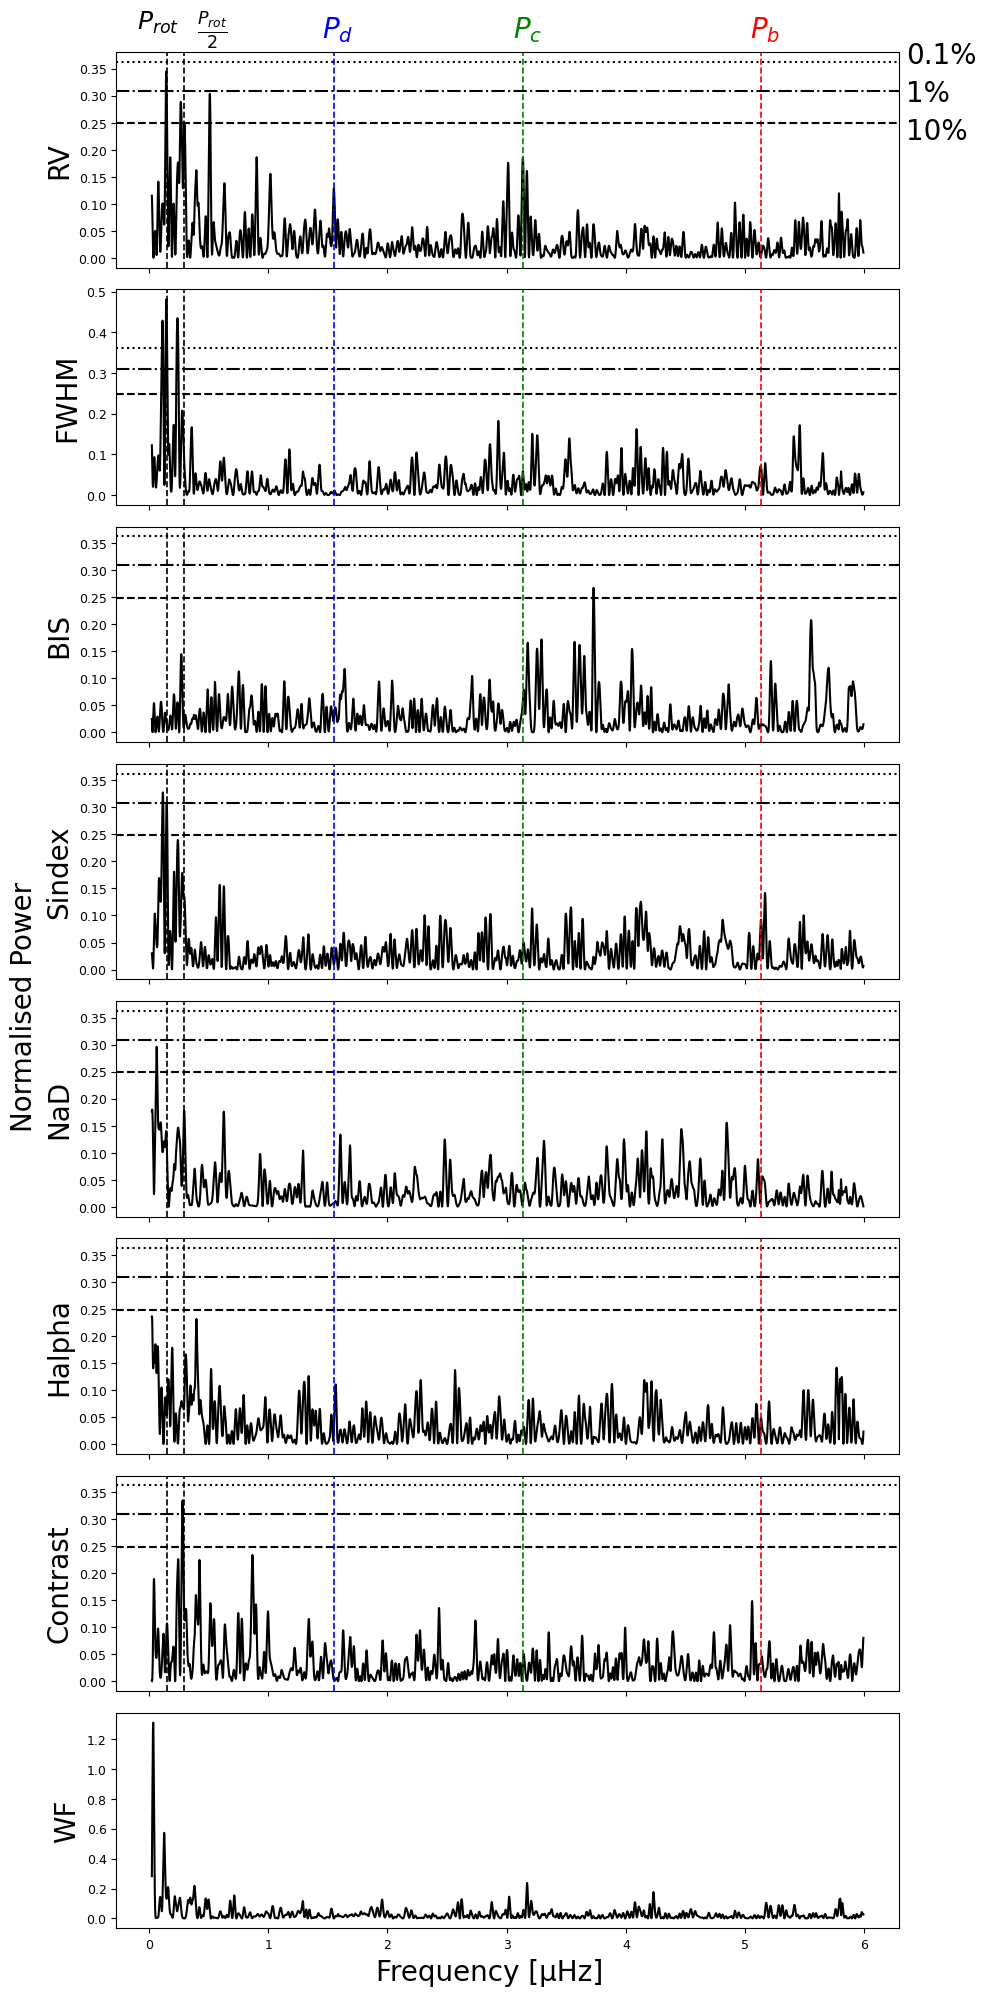

In [13]:
# True values (accoridng to paper (D. S. Demangeon et al. 2021))
true_periods = [2.2531136, 3.6906777,  7.4507245, 78.22, 78.22 / 2]
period_colors = ['red', 'green', 'blue', 'black', 'black']  # Define more colors if there are more true periods

# Extract data
activity_indices = ['RV', 'FWHM', 'BIS', 'Sindex', 'NaD', 'Halpha', 'Contrast']

# Determine the frequency range days
# min_frequency = 1 / (time.max() - time.min())  # Longest period
min_frequency = 0.002025227467386652 # min frequency ESPRESSO
#min_frequency = 0.0036063525167432157
max_frequency = 0.5177264355163222   # max frequency HARPS
samples_per_peak = 3000

plot_periodogram(ESPRESSO_times, ESPRESSO_df, activity_indices, true_periods, period_colors, min_frequency, max_frequency, samples_per_peak, ESPRESSO=True)

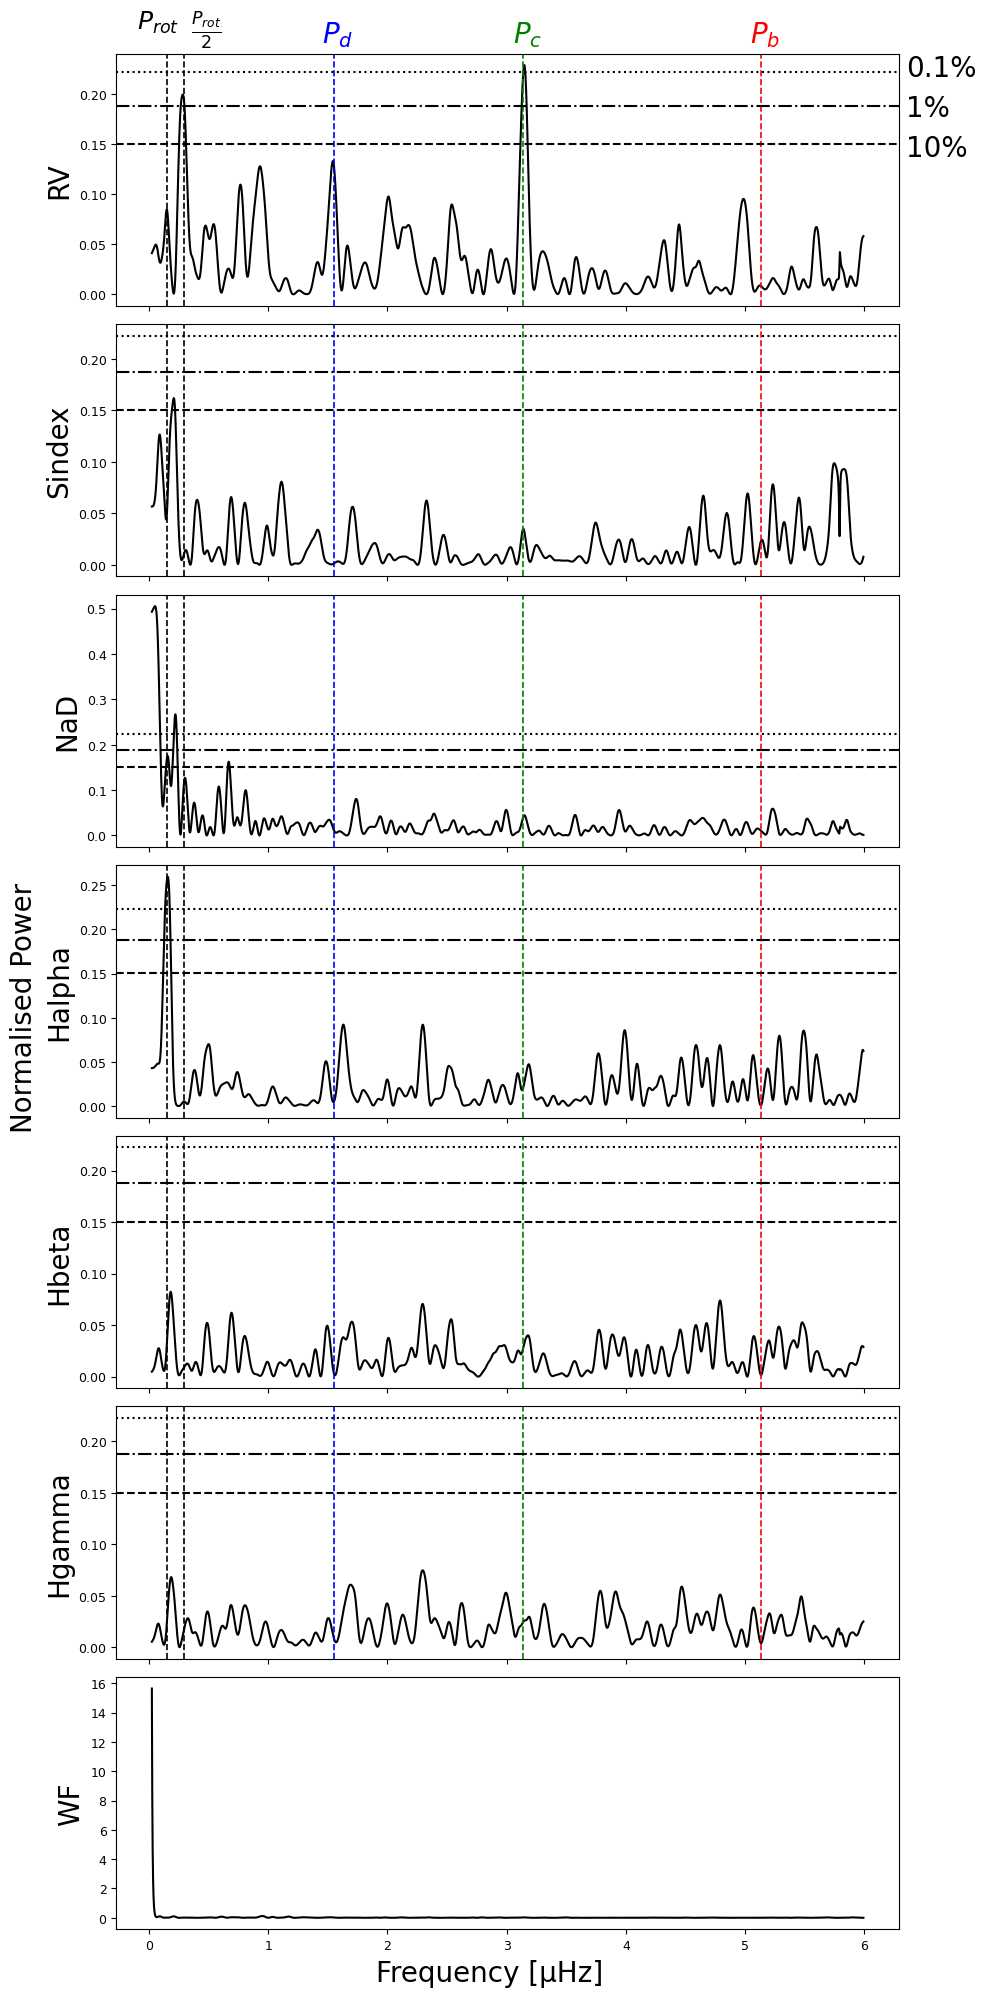

In [14]:
# Extract data
activity_indices = ['RV', 'Sindex', 'NaD', 'Halpha', 'Hbeta', 'Hgamma']


plot_periodogram(HARPS_times, cleaned_HARPS_df, activity_indices, true_periods, period_colors, min_frequency, max_frequency, samples_per_peak, ESPRESSO=False)

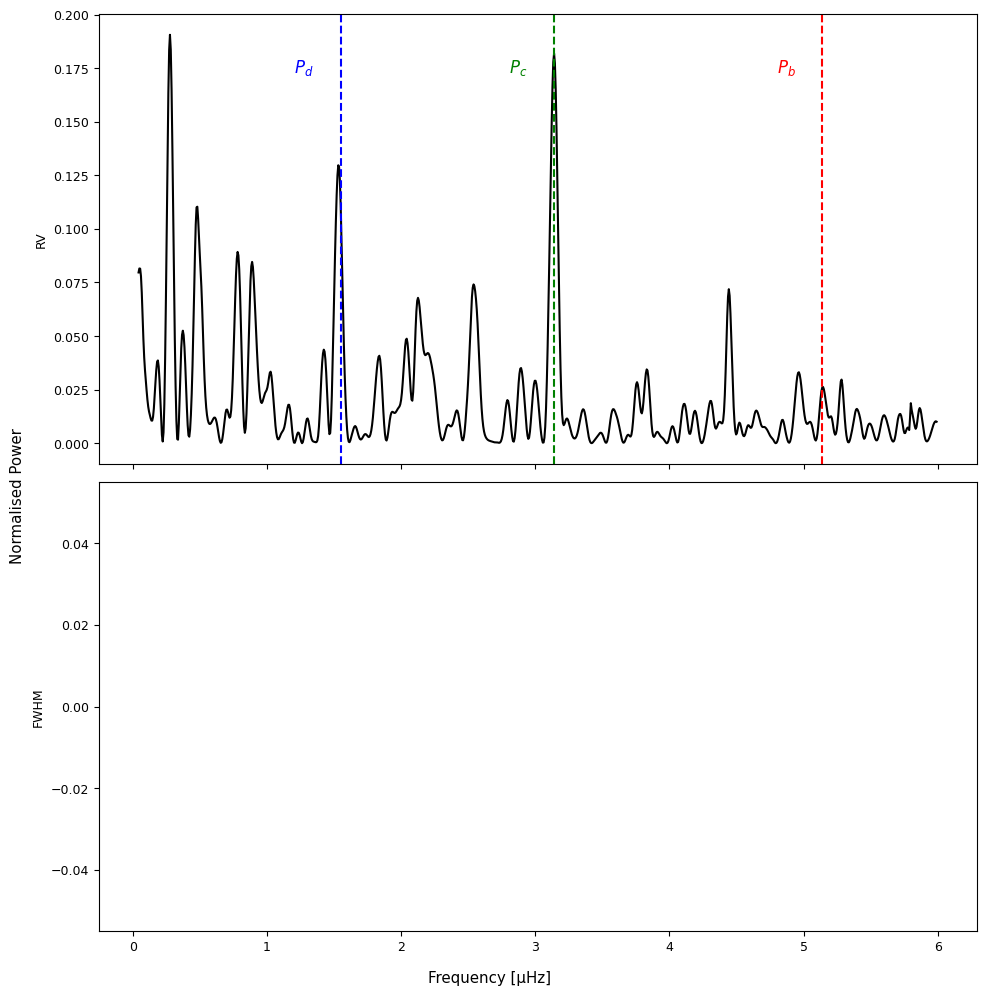

In [5]:
# True values (accoridng to paper (D. S. Demangeon et al. 2021))
true_periods = [2.2531136, 3.6906777,  7.4507245]
period_colors = ['red', 'green', 'blue']  # Define more colors if there are more true periods

# Plotting
fig, axes = plt.subplots(len(periodograms), 1, figsize=(10, 10), sharex=True)

colors = ['b', 'g', 'c', 'm', 'y', 'k']  # Extend this list if you have more than six lines

for i, (ax, (key, (frequency, power))) in enumerate(zip(axes, periodograms.items())):
    # Plot each line in a different color
    ax.plot(convert_to_microhertz(frequency), power, color='black', label=key)
    ax.set_ylabel(key)
    if i < len(axes) - 1:
        for peak, color in zip(true_periods, period_colors):
            ax.axvline(x=convert_to_microhertz(1 / peak), color=color, linestyle='--', label=f'True Period: {peak} days')

    if i == 0:
        ax.text(1.2, 0.18, r'$P_d$', color='b', verticalalignment='top', size=12)
        ax.text(2.8, 0.18, r'$P_c$', color='g', verticalalignment='top', size=12)
        ax.text(4.80, 0.18, r'$P_b$', color='r', verticalalignment='top', size=12)

# common axis labels
fig.supxlabel('Frequency [µHz]')
fig.supylabel('Normalised Power')

plt.tight_layout()
plt.show()